In [110]:
import re, os, sys, glob
from pathlib import Path
from collections import Counter
import pickle 

import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from lime import lime_text
from lime.lime_text import LimeTextExplainer

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 8)

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
np.warnings.filterwarnings('ignore')

In [3]:
train_data_folder = "../train-data/"

data = []

for path in glob.glob('%s/*.txt'%train_data_folder):
    print(path)
    filename = os.path.basename(path).split('.')[0]
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.readlines()
    for l in text:
        data.append((l, filename))

../train-data/note.txt
../train-data/cf.txt
../train-data/bs.txt
../train-data/is.txt
../train-data/plaintext.txt


In [4]:
data[:3]

[('CASH FLOW FROM FINANCING ACTIVITIES\n', 'note'),
 ('Increase in Borrowings 241,003,504 43,568,618\n', 'note'),
 ('Tier II Debt raised 70,000,000 -\n', 'note')]

In [5]:
def preprocessor(x):
    x = re.sub(r'[0-9\,]+', 'num', x)
    return re.sub(r'[\n()]+', ' ', x).lower()

In [6]:
df = pd.DataFrame(data, columns=['raw', 'type'])
df['clean'] = df.raw.apply(preprocessor)
df.head()

,raw,type,clean
0,CASH FLOW FROM FINANCING ACTIVITIES\n,note,cash flow from financing activities
1,"Increase in Borrowings 241,003,504 43,568,618\n",note,increase in borrowings num num
2,"Tier II Debt raised 70,000,000 -\n",note,tier ii debt raised num -
3,"Innovative Perpetual Debt raised 54,150,000 30...",note,innovative perpetual debt raised num num
4,"Tier II Debt repaid during the year (2,489,000...",note,tier ii debt repaid during the year num num


In [7]:
Counter(df.type)

Counter({'note': 313, 'cf': 102, 'bs': 107, 'is': 92, 'plaintext': 93})

In [8]:
nb = make_pipeline(TfidfVectorizer(min_df=2, ngram_range=(1, 3), stop_words={'english'}),
                   MultinomialNB(alpha=0.1)
                    )

X = df['clean']
y= df.type
nb.fit(X, y)
y_pred_class = nb.predict(X)
# print(y_pred_class)
metrics.accuracy_score(y, y_pred_class)

0.867043847241867

In [15]:
train_data_folder = "../train-data/"

data = []

for path in glob.glob('%s/*.txt'%train_data_folder):
    print(path)
    filename = os.path.basename(path).split('.')[0]
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    data.append((text.lower(), filename))

../train-data/note.txt
../train-data/cf.txt
../train-data/bs.txt
../train-data/is.txt
../train-data/plaintext.txt


In [16]:
data[0]

("cash flow from financing activities\nincrease in borrowings 241,003,504 43,568,618\ntier ii debt raised 70,000,000 -\ninnovative perpetual debt raised 54,150,000 30,000,000\ntier ii debt repaid during the year (2,489,000) (3,786,000)\nproceeds from issue of share capital (net of share issue expense) 1,420,167 49,576,625\ndividend paid during the year (5,488,101) (4,209,981)\ntax on dividend paid (1,117,377) (857,152)\nnet cash generated from/(used in) financing activities (c) 357,479,193 114,292,110\neffect of exchange fluctuation on translation reserve (d) 65,803 (37,234)\nnet increase in cash and cash equivalents (a+b+c+d) 51,849,223 113,310,194\ncash and cash equivalents as at april 1st 195,494,441 82,184,247\ncash and cash equivalents as at mar 31st 247,343,664 195,494,441\nnotes to the cash flow statement:\ncash and cash equivalents includes the following\ncash and balances with reserve bank of india 114,257,489 69,520,697\nbalances with banks and money at call and short notice 

In [17]:
df = pd.DataFrame(data, columns=['raw', 'type'])
df['clean'] = df.raw.apply(preprocessor)
df

,raw,type,clean
0,cash flow from financing activities\nincrease ...,note,cash flow from financing activities increase i...
1,cash flow from operating activities\nnet profi...,cf,cash flow from operating activities net profit...
2,"capital and liabilities\ncapital 1 4,605,934 4...",bs,capital and liabilities capital num num num re...
3,"income\ninterest earned 13 202,674,216 164,246...",is,income interest earned num num num other incom...
4,"resolved further that, for the purpose of\ngiv...",plaintext,resolved further thatnum for the purpose of gi...


In [18]:
# vect = HashingVectorizer(non_negative=True)
# X = vect.fit_transform(df['clean'])
# y= df.type
# nb = MultinomialNB()
# nb.fit(X, y)
# y_pred_class = nb.predict(X)
# print(y_pred_class)
# metrics.accuracy_score(y, y_pred_class)

# Testing

In [19]:
X = df['clean']
y= df.type
y_pred_class = nb.predict(X)
y_pred_class_proba = nb.predict_proba(X)
print(y_pred_class)
print(np.round(y_pred_class_proba, 3))
print(np.max(y_pred_class_proba, axis=1))
print('Accuracy: %s'%metrics.accuracy_score(y, y_pred_class))

['note' 'cf' 'bs' 'is' 'plaintext']
[[0.    0.    0.    1.    0.   ]
 [0.    1.    0.    0.    0.   ]
 [0.979 0.008 0.006 0.006 0.   ]
 [0.003 0.001 0.993 0.003 0.   ]
 [0.    0.    0.    0.    1.   ]]
[0.99996441 0.9995002  0.97923128 0.99314885 1.        ]
Accuracy: 1.0


In [20]:
pickle.dump(nb, open('models/mindf2.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'models/mindf2.pkl'

In [21]:
test ="""
Particulars For the year ended
March 31, 2017
For the year ended
March 31, 2016
(C) CASH FLOW FROM FINANCING ACTIVITIES
Financing of hedging contract (6.71) 20.17
Interest Costs (4.11) (27.57)
Net Cash from /(Used) in Financing Activities (III) (10.82) (7.40)
Net Increase /(Decrease) in Cash & Cash equivalents (I+ II+ III) 605.75 62.86
Cash & Cash equivalents at the beginning of the year 941.89 879.03
Cash & Cash equivalents at the end of the year 1,547.64 941.89
Notes :
1 ) Cash and Cash equivalents include cash and bank balances in current accounts and deposit accounts. (Refer Note no. 8 (d))
2) Previous year figures have been regrouped wherever necessary to correspond with the figures of the current year.
As per our attached report of even date.
For and on behalf of For and on behalf of the Board of Directors
KHIMJI KUNVERJI & CO. APTECH LIMITED
Chartered Accountants
(Firm Registration No. 105146W)
ANIL PANT C. Y. PAL
Managing Director & CEO Vice Chairman
SHIVJI K VIKAMSEY (Din :07565631) (Din: 00106536)
Partner
(M.No 2242)
Place : Mumbai T. K. RAVISHANKAR KETAN SHAH
Date : May 24, 2017 Executive Vice President & CFO Company Secretary
"""


def predict_table_type(x):
    x = preprocessor(x)
    print(x)
    print('Probability: %s'%np.max(nb.predict_proba([x])))
    return nb.predict([x])[0]
    
predict_table_type(test)

 particulars for the year ended march num num for the year ended march num num c  cash flow from financing activities financing of hedging contract  num.num  num.num interest costs  num.num   num.num net cash from / used  in financing activities  iii   num.num   num.num net increase / decrease  in cash & cash equivalents  i+ ii+ iii  num.num num.num cash & cash equivalents at the beginning of the year num.num num.num cash & cash equivalents at the end of the year num.num num.num notes : num   cash and cash equivalents include cash and bank balances in current accounts and deposit accounts.  refer note no. num  d num  previous year figures have been regrouped wherever necessary to correspond with the figures of the current year. as per our attached report of even date. for and on behalf of for and on behalf of the board of directors khimji kunverji & co. aptech limited chartered accountants firm registration no. numw anil pant c. y. pal managing director & ceo vice chairman shivji k vik

'cf'

## Lime

In [96]:
class_names = y_pred_class
num_classes = len(class_names)
explainer = LimeTextExplainer(class_names=class_names)

In [97]:
X.shape

(5,)

In [98]:
idx = 1
num_features = 20
exp = explainer.explain_instance(X[idx], nb.predict_proba, num_features=num_features, labels=range(num_classes))
print('Document id: %d' % idx)
print('Predicted class =', nb.predict([X[idx]]).reshape(1,-1)[0,0])
print('Predicted class =', nb.predict_proba([X[idx]]))
print('True class: %s' % y[idx])

Document id: 1
Predicted class = cf
Predicted class = [[1.15059052e-04 9.99500204e-01 2.19538272e-05 3.62782117e-04
  1.16234714e-09]]
True class: cf


In [99]:
for i in range(num_classes):
    print('\nExplanation for class %s' % class_names[i])
    print('\n'.join(map(str, exp.as_list(label=i))))


Explanation for class note
('num', 0.052897526070113284)
('of', -0.017046599427144763)
('cash', -0.015914586068634388)
('from', -0.012314485677010855)
('year', -0.012273409700040183)
('activities', -0.009145828659056943)
('the', -0.009048788530079115)
('increase', -0.008794297404891408)
('in', -0.008389651025118763)
('decrease', -0.007205009662165026)
('equivalents', -0.006321170620577644)
('net', -0.006255234686782837)
('flow', -0.00618125552956396)
('subsidiaries', -0.0057559712741723)
('months', -0.005671550476899471)
('purchase', -0.005325753339227507)
('numst', -0.005239368532508877)
('generated', -0.004891349603165843)
('at', -0.004881766219023773)
('d', 0.0015205178898384665)

Explanation for class cf
('num', -0.1460368910681532)
('cash', 0.052069527195288824)
('of', 0.04115386819709351)
('decrease', 0.0318534572582234)
('from', 0.031174169193615958)
('equivalents', 0.026816204529389303)
('increase', 0.025215145547553733)
('year', 0.024639357524845626)
('activities', 0.02414603

## Explain only top labels

In [100]:
top_labels = 2
exp = explainer.explain_instance(X[idx], nb.predict_proba, num_features=num_features, top_labels=top_labels)
best_labels = exp.available_labels()
print(best_labels)

[1, 3]


In [101]:
for i in best_labels:
    print('\nExplanation for class %s' % class_names[i])
    print('\n'.join(map(str, exp.as_list(label=i))))


Explanation for class cf
('num', -0.15733592540321792)
('cash', 0.058266574672465724)
('of', 0.036362185342897264)
('activities', 0.032958053524719894)
('decrease', 0.029812126057182288)
('increase', 0.02868752339551543)
('from', 0.02652999166927619)
('equivalents', 0.02457203272649624)
('flow', 0.021806098181601757)
('in', 0.021413839112259532)
('sale', 0.021355537558538376)
('year', 0.020301925461836196)
('issue', 0.0195731284524889)
('investing', 0.01935589788459269)
('period', 0.018650480091634038)
('liabilities', 0.01845788747083624)
('pursuant', 0.01710528564518141)
('financing', 0.016214831069208645)
('numst', 0.01583723331865089)
('non', 0.01458902618765909)

Explanation for class is
('num', 0.07458904475086363)
('cash', -0.026238648872549546)
('decrease', -0.019843344076120952)
('of', -0.016490765243649255)
('activities', -0.013975557924247041)
('increase', -0.013765825866876972)
('equivalents', -0.013419777927490687)
('investing', -0.013022243282316388)
('from', -0.011993940

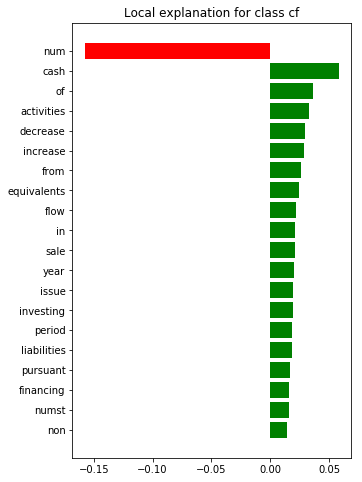

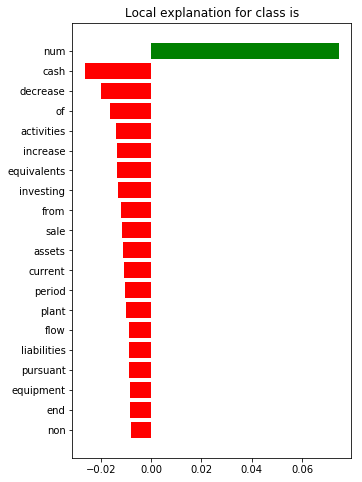

In [112]:
plt.rcParams["figure.figsize"] = (5, 8)

for i in best_labels:
    fig = exp.as_pyplot_figure(label=i)